## Refreshment Project 2.0 - Home Prices Prediction - Ames Housing

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

In [63]:
df = pd.read_csv("AmesHousing.csv")
print("shape:", df.shape)
df.head()

shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [64]:
df_numeric = df.select_dtypes(include=["int64", "float64"])

In [65]:
df_numeric.corr()["SalePrice"].sort_values(ascending=False)

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Screen Porch       0.112151
Pool Area          0.068403
Mo Sold            0.035259
3Ssn Porch         0.032225
BsmtFin SF 2       0.005891
Misc Val          -0.015691
Yr Sold           -0.030569
Order             -0.031408
Bsmt Half Bath    -0.035835
Low Qual Fin SF   -0.037660
MS SubClass       -0.085092
Overall Cond      -0

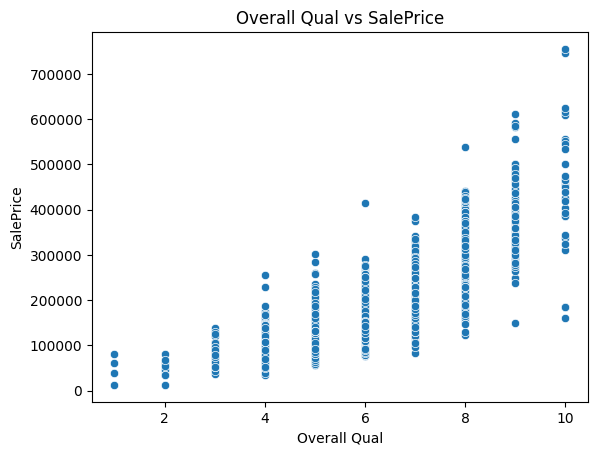

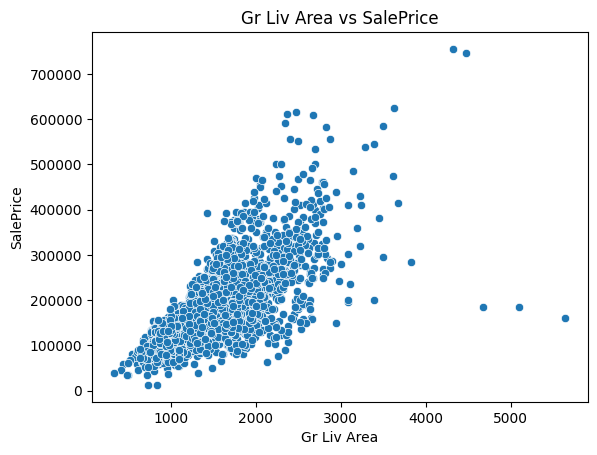

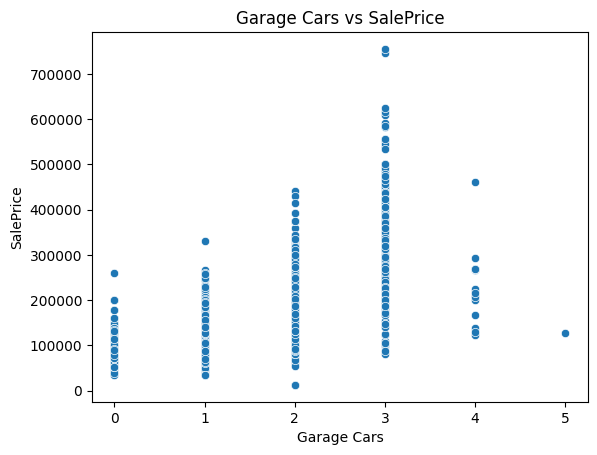

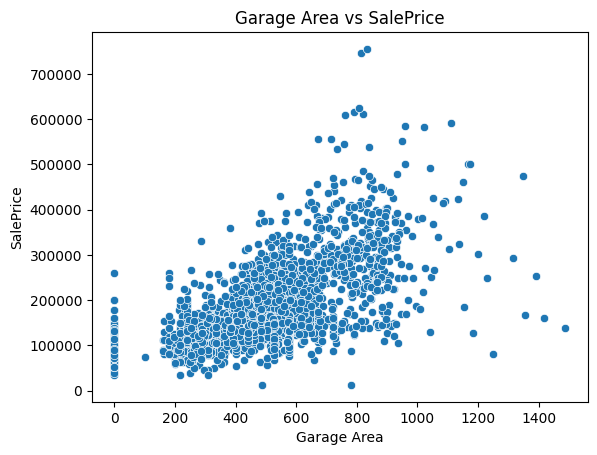

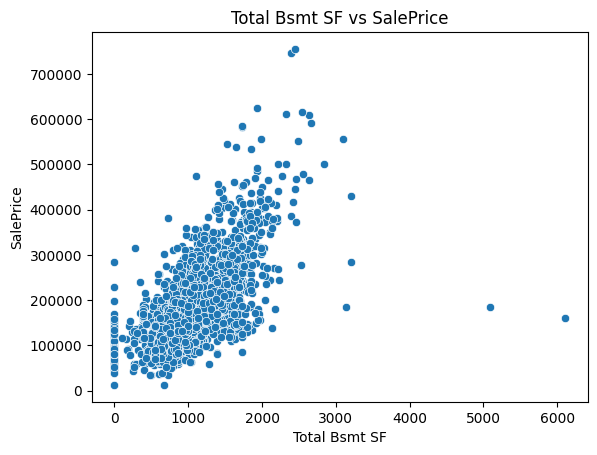

In [66]:
important_features = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Garage Area", "Total Bsmt SF"]
for col in important_features:
    sns.scatterplot(data=df, x=col, y="SalePrice")
    plt.title(f"{col} vs SalePrice")
    plt.show()


### NA Handling

In [67]:
df.isna().sum().sort_values(ascending=False)

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
                  ... 
Mo Sold              0
Yr Sold              0
Sale Type            0
Sale Condition       0
SalePrice            0
Length: 82, dtype: int64

In [68]:
na_pct = df.isna().mean() * 100
na_over_30 = na_pct[na_pct > 30].sort_values(ascending=False)
print(na_over_30)

Pool QC         99.556314
Misc Feature    96.382253
Alley           93.242321
Fence           80.477816
Mas Vnr Type    60.580205
Fireplace Qu    48.532423
dtype: float64


#### dropping columns with more than 30% of NA values

In [69]:
df = df.drop(columns=["Pool QC", "Misc Feature", "Alley", "Fence", "Mas Vnr Type", "Fireplace Qu"])

#### filling NA in Lot Frontage by the Neightborhood column

In [70]:
df["Lot Frontage"].value_counts()

Lot Frontage
60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
        ... 
168.0      1
111.0      1
131.0      1
153.0      1
133.0      1
Name: count, Length: 128, dtype: int64

In [71]:
df[["Lot Frontage", "Neighborhood"]]

,Lot Frontage,Neighborhood
0,141.0,NAmes
1,80.0,NAmes
2,81.0,NAmes
3,93.0,NAmes
4,74.0,Gilbert
...,...,...
2925,37.0,Mitchel
2926,NaN,Mitchel
2927,62.0,Mitchel
2928,77.0,Mitchel


In [72]:
df["Lot Frontage"] = df["Lot Frontage"].fillna(df.groupby("Neighborhood")["Lot Frontage"].transform("median"))

In [73]:
#check
df["Lot Frontage"].isna().sum()

np.int64(3)

#### still 3 nans - will use overall median to fill missing values

In [74]:
med_lf = df["Lot Frontage"].median()
df["Lot Frontage"] = df["Lot Frontage"].fillna(med_lf)

In [75]:
df["Lot Frontage"].isna().sum()
#0

np.int64(0)

#### handling Nan with "None" in object columns

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2930 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Lot Shape        2930 non-null   object 
 8   Land Contour     2930 non-null   object 
 9   Utilities        2930 non-null   object 
 10  Lot Config       2930 non-null   object 
 11  Land Slope       2930 non-null   object 
 12  Neighborhood     2930 non-null   object 
 13  Condition 1      2930 non-null   object 
 14  Condition 2      2930 non-null   object 
 15  Bldg Type        2930 non-null   object 
 16  House Style      2930 non-null   object 
 17  Overall Qual  

In [77]:
df_object_cols = df.select_dtypes(include=["object"]).columns


In [78]:
df[df_object_cols] = df[df_object_cols].fillna("None")

In [79]:
df_object_cols.isna().sum()

np.int64(0)

In [80]:
df.isna().sum().sort_values(ascending=False).head(10)


Garage Yr Blt     159
Mas Vnr Area       23
Bsmt Full Bath      2
Bsmt Half Bath      2
BsmtFin SF 2        1
BsmtFin SF 1        1
Total Bsmt SF       1
Bsmt Unf SF         1
Garage Area         1
Garage Cars         1
dtype: int64

In [81]:
cols_to_fill = [
    "Garage Yr Blt", "Mas Vnr Area", "Bsmt Half Bath", "Bsmt Full Bath",
    "Total Bsmt SF", "Bsmt Unf SF", "BsmtFin SF 2", "BsmtFin SF 1",
    "Garage Cars", "Garage Area"
]

for col in cols_to_fill:
    df[col] = df[col].fillna(df[col].median())


In [82]:
df.isna().sum().sort_values(ascending=False)

Order             0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage      0
                 ..
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
Length: 76, dtype: int64

### Feature Engineering

In [83]:
#1. TotalSF

df["TotalSF"] = df["Total Bsmt SF"] + df["1st Flr SF"] + df["2nd Flr SF"]

In [84]:
#drop redundand columns:
df = df.drop(columns=["Total Bsmt SF","1st Flr SF", "2nd Flr SF"],errors="ignore")

In [85]:
#2. TotalBathrooms

df["TotalBathrooms"] = df["Full Bath"] + df["Half Bath"]*0.5 + df["Bsmt Full Bath"] + df["Bsmt Half Bath"]*0.5

In [86]:
df = df.drop(columns=["Full Bath", "Half Bath", "Bsmt Full Bath", "Bsmt Half Bath"], errors="ignore")

In [87]:
def get_remodeled(row):
    if row["Year Built"] != row["Year Remod/Add"]:
        return 1
    else:
        return 0

In [88]:
df["IsRemodeled"] = df.apply(get_remodeled, axis=1)

In [89]:
df["HouseAge"] = df["Yr Sold"] - df["Year Built"]
df["GarageAge"] = df["Yr Sold"] - df["Garage Yr Blt"]

### Data Prep for Modelling

In [90]:
df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch

In [91]:
df_model = df[["SalePrice", "Overall Qual", "Gr Liv Area", "Garage Cars", "TotalSF", "TotalBathrooms", "IsRemodeled", "HouseAge", "GarageAge", "Neighborhood", "MS Zoning"]]

In [92]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SalePrice       2930 non-null   int64  
 1   Overall Qual    2930 non-null   int64  
 2   Gr Liv Area     2930 non-null   int64  
 3   Garage Cars     2930 non-null   float64
 4   TotalSF         2930 non-null   float64
 5   TotalBathrooms  2930 non-null   float64
 6   IsRemodeled     2930 non-null   int64  
 7   HouseAge        2930 non-null   int64  
 8   GarageAge       2930 non-null   float64
 9   Neighborhood    2930 non-null   object 
 10  MS Zoning       2930 non-null   object 
dtypes: float64(4), int64(5), object(2)
memory usage: 251.9+ KB


In [93]:
df_modelling = pd.get_dummies(df_model, columns=["Neighborhood","MS Zoning"], drop_first=True)

In [94]:
X = df_modelling.drop("SalePrice", axis=1)
y = df_modelling["SalePrice"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=1337)

In [95]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.66, random_state=1337)

In [96]:
print(X_train.shape, X_val.shape, X_test.shape)

(2051, 41) (580, 41) (299, 41)


### Random Forest Regressor

In [97]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_val)

rmse_rf = root_mean_squared_error(y_true=y_val, y_pred=y_pred_rf)
mae_rf = mean_absolute_error(y_true=y_val, y_pred=y_pred_rf)
r2_rf = r2_score(y_val,y_pred_rf)

print(f"r2: {r2_rf}\nMAE: {mae_rf}\nRMSE: {rmse_rf}")

r2: 0.8879803495285393
MAE: 16942.772920060208
RMSE: 24361.720405246513


### XGB

In [98]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_val)

rmse_xgb = root_mean_squared_error(y_true=y_val, y_pred=y_pred_xgb)
mae_xgb = mean_absolute_error(y_true=y_val, y_pred=y_pred_xgb)
r2_xgb = r2_score(y_val,y_pred_xgb)

print(f"r2: {r2_xgb}\nMAE: {mae_xgb}\nRMSE: {rmse_xgb}")


r2: 0.891288161277771
MAE: 16799.603515625
RMSE: 23999.3359375


### Linear Models

In [109]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



#### Logistic Regression

In [110]:
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_val_scaled)

rmse_lr = root_mean_squared_error(y_true=y_val, y_pred=y_pred_lr)
mae_lr = mean_absolute_error(y_true=y_val, y_pred=y_pred_lr)
r2_lr = r2_score(y_val,y_pred_lr)

print(f"r2: {r2_lr}\nMAE: {mae_lr}\nRMSE: {rmse_lr}")

r2: 0.8569281423512345
MAE: 18901.650670891893
RMSE: 27532.012369403572


#### Lasso

In [113]:
model_lasso = Lasso(max_iter=5000)
model_lasso.fit(X_train_scaled, y_train)
y_pred_lasso = model_lasso.predict(X_val_scaled)

rmse_lasso = root_mean_squared_error(y_true=y_val, y_pred=y_pred_lasso)
mae_lasso = mean_absolute_error(y_true=y_val, y_pred=y_pred_lasso)
r2_lasso = r2_score(y_val,y_pred_lasso)

print(f"r2: {r2_lasso}\nMAE: {mae_lasso}\nRMSE: {rmse_lasso}")

r2: 0.8568773339862024
MAE: 18905.521357789978
RMSE: 27536.900585672673


#### Ridge

In [114]:
model_ridge = Ridge(max_iter=5000)
model_ridge.fit(X_train_scaled, y_train)
y_pred_ridge = model_ridge.predict(X_val_scaled)

rmse_ridge = root_mean_squared_error(y_true=y_val, y_pred=y_pred_ridge)
mae_ridge = mean_absolute_error(y_true=y_val, y_pred=y_pred_ridge)
r2_ridge = r2_score(y_val,y_pred_ridge)

print(f"r2: {r2_lasso}\nMAE: {mae_lasso}\nRMSE: {rmse_lasso}")

r2: 0.8568773339862024
MAE: 18905.521357789978
RMSE: 27536.900585672673


In [120]:
def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }


results = [
    evaluate_model("Ridge", y_val, y_pred_ridge),
    evaluate_model("Lasso", y_val, y_pred_lasso),
    evaluate_model("RandomForest", y_val, y_pred_rf),
    evaluate_model("XGB", y_val, y_pred_xgb),
    evaluate_model("LR", y_val, y_pred_lr)
]

df_results = pd.DataFrame(results)


In [121]:
df_results.sort_values(by="R2", ascending=False)

,Model,RMSE,MAE,R2
3,XGB,23999.335938,16799.603516,0.891288
2,RandomForest,24361.720405,16942.772920,0.887980
4,LR,27532.012369,18901.650671,0.856928
1,Lasso,27536.900586,18905.521358,0.856877
0,Ridge,27541.256795,18907.784033,0.856832
